# Machinaal Leren - Sprint 2: Text Data

## Task:
What insights can we gain from the text data (title, description and reviews) ?

Possible tasks:
* Detect duplicate listings
* Extract keywords from reviews / descriptions
* Automatically make a list of positive and negative points for a listing based on the reviews
* Recognize listings from the same owner
* Detect anomalies (listings/ reviews that are very different from other listings/ reviews)
* Detect reviews that are very similar
* Perform sentiment analysis on a review
* ...

## Work table


|Task|Peter Bonnarens|Philip Kukoba|Lennert Franssens|
|------|------|------|------|
|Detect duplicate listings  |X  |X  | X |
|Extract keywords  |_  |_  | _ |
|Automatically make a list  |_  |_  | _ |
|Recognize listings from the same owner  |_  |_  | _ |
|Detect anomalies  |_  |_  | _ |
|Detect reviews that are very similar  |_  |_  | _ |
|Perform sentiment analysis on a review  |_  |_  | _ |

# 1 - Loading the dataset

In [132]:
%matplotlib inline

# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  
import seaborn as sns 
from matplotlib import rcParams
import warnings

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', -1)
# delete warnings from output
warnings.filterwarnings('ignore')

# figure size in inches
plt.rcParams['figure.figsize'] = 15, 12

# loading the datasets into pandas dataframes
reviews = pd.read_csv("data/reviews.csv")
listings = pd.read_csv("data/listings.csv")

In [133]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,187870,540088,2011-09-17,1003634,Dominick,"This is a very lovely room. The room, bathroom..."
1,187870,581572,2011-09-29,178012,Nancy,Tamara's place in Ghent was really nice and cl...
2,187870,715167,2011-11-13,1391583,Charlotte,We spend one night at Tamara's and it was perf...
3,187870,834756,2012-01-03,1513484,Ger Y Flo,"Pasamos unos dias increibles en Gante, la habi..."
4,187870,855004,2012-01-10,1503813,Max,My girlfriend and I had the most wonderful tim...


In [134]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,Unnamed: 74
0,187870,https://www.airbnb.com/rooms/187870,20210716195504,2021-07-16,Luxury studio 'Spiegelhof' in the centre of Ghent,The top floor of our house in the center of Gh...,We live in a quiet and pleasant neighborhood w...,https://a0.muscache.com/pictures/26c46224-795c...,904277,https://www.airbnb.com/users/show/904277,...,4.58,4.85,NaN,t,1,0,1,0,3.61,NaN
1,203806,https://www.airbnb.com/rooms/203806,20210716195504,2021-07-16,Flat close to Sint-Pieters Station!,This well-located and comfortable one-bedroom ...,The house is located in a dead-end street - so...,https://a0.muscache.com/pictures/fe477b7f-93ac...,999847,https://www.airbnb.com/users/show/999847,...,4.49,4.54,NaN,f,2,2,0,0,2.84,NaN
2,204245,https://www.airbnb.com/rooms/204245,20210716195504,2021-07-16,Modern studio's in Ghent centre,<b>The space</b><br />We offer luxury studio's...,NaN,https://a0.muscache.com/pictures/1766072/02965...,1003009,https://www.airbnb.com/users/show/1003009,...,4.97,4.63,NaN,f,2,2,0,0,0.29,NaN
3,216715,https://www.airbnb.com/rooms/216715,20210716195504,2021-07-16,converted loft,Please read full desription for how to get the...,It's close to all that you will want or need v...,https://a0.muscache.com/pictures/1927009/20760...,911466,https://www.airbnb.com/users/show/911466,...,4.89,4.76,NaN,t,1,1,0,0,4.31,NaN
4,252269,https://www.airbnb.com/rooms/252269,20210716195504,2021-07-16,Large & bright town House - Center Ghent - max 8p,"bright, spacious, authentic & beautifully rest...","our neighbourhood is quiet, but nicely vibrati...",https://a0.muscache.com/pictures/69675b54-3e78...,1195314,https://www.airbnb.com/users/show/1195314,...,4.98,4.72,NaN,f,1,1,0,0,2.23,NaN


Find lines to shift and add them to a mask - we've found that some lines are shifted 1 to the right beginning on the host_id column (that now contains garbage data)

In [135]:
shifted_lines = listings[pd.to_numeric(listings["host_verifications"], errors='coerce').notnull()].id
mask = listings['id'].isin(shifted_lines)

# shift lines 1 to the left
listings.loc[mask, 'host_since':'reviews_per_month'] = listings.loc[mask, 'host_since':'reviews_per_month'].shift(-1, axis=1)

In [136]:
listings.drop(['host_response_time','host_response_rate','host_acceptance_rate','host_is_superhost','host_listings_count','host_total_listings_count',
            'host_has_profile_pic','host_identity_verified','latitude','longitude','accommodates','bathrooms','bedrooms','beds','price','minimum_nights',
            'maximum_nights','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm',
            'maximum_nights_avg_ntm','calendar_updated','has_availability','availability_30','availability_60','availability_90','availability_365',
            'number_of_reviews','number_of_reviews_ltm','number_of_reviews_l30d','first_review','last_review','license','instant_bookable','calculated_host_listings_count',
            'calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms',
            'reviews_per_month'], axis=1)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,amenities,calendar_last_scraped,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,Unnamed: 74
0,187870,https://www.airbnb.com/rooms/187870,20210716195504,2021-07-16,Luxury studio 'Spiegelhof' in the centre of Ghent,The top floor of our house in the center of Gh...,We live in a quiet and pleasant neighborhood w...,https://a0.muscache.com/pictures/26c46224-795c...,904277,https://www.airbnb.com/users/show/904277,...,"[""Microwave"", ""Keypad"", ""Extra pillows and bla...",2021-07-16,4.85,4.90,4.95,4.90,4.87,4.58,4.85,NaN
1,203806,https://www.airbnb.com/rooms/203806,20210716195504,2021-07-16,Flat close to Sint-Pieters Station!,This well-located and comfortable one-bedroom ...,The house is located in a dead-end street - so...,https://a0.muscache.com/pictures/fe477b7f-93ac...,999847,https://www.airbnb.com/users/show/999847,...,"[""Dishwasher"", ""Ethernet connection"", ""Microwa...",2021-07-16,4.59,4.72,4.73,4.80,4.79,4.49,4.54,NaN
2,204245,https://www.airbnb.com/rooms/204245,20210716195504,2021-07-16,Modern studio's in Ghent centre,<b>The space</b><br />We offer luxury studio's...,NaN,https://a0.muscache.com/pictures/1766072/02965...,1003009,https://www.airbnb.com/users/show/1003009,...,"[""Shampoo"", ""Wifi"", ""TV"", ""Heating"", ""Dedicate...",2021-07-16,4.79,4.73,4.93,4.83,4.70,4.97,4.63,NaN
3,216715,https://www.airbnb.com/rooms/216715,20210716195504,2021-07-16,converted loft,Please read full desription for how to get the...,It's close to all that you will want or need v...,https://a0.muscache.com/pictures/1927009/20760...,911466,https://www.airbnb.com/users/show/911466,...,"[""Long term stays allowed"", ""Microwave"", ""Cook...",2021-07-16,4.75,4.81,4.90,4.89,4.85,4.89,4.76,NaN
4,252269,https://www.airbnb.com/rooms/252269,20210716195504,2021-07-16,Large & bright town House - Center Ghent - max 8p,"bright, spacious, authentic & beautifully rest...","our neighbourhood is quiet, but nicely vibrati...",https://a0.muscache.com/pictures/69675b54-3e78...,1195314,https://www.airbnb.com/users/show/1195314,...,"[""Hot water kettle"", ""Dishwasher"", ""Microwave""...",2021-07-16,4.89,4.92,4.93,4.92,4.97,4.98,4.72,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,51022259,https://www.airbnb.com/rooms/51022259,20210716195504,2021-07-16,Full apartment near Sint Pieters Station,This is a 2 bedroom apartment. Guests will en...,Apartment is located in neighborhood of Sint P...,the main station in Ghent. The street is very...,https://a0.muscache.com/pictures/47c0402d-8d28...,97573561,...,"[""Microwave"", ""Fire extinguisher"", ""Dishes and...",2021-07-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
919,51036302,https://www.airbnb.com/rooms/51036302,20210716195504,2021-07-16,Guesthouse Flora,Geniet van de moderne en ouderwetse charme van...,De Flora is het meest noordelijke gedeelte van...,https://a0.muscache.com/pictures/186f59af-f089...,171955140,https://www.airbnb.com/users/show/171955140,...,"[""Hot water kettle"", ""Microwave"", ""Extra pillo...",2021-07-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
920,51053223,https://www.airbnb.com/rooms/51053223,20210716195504,2021-07-16,Large modern house 10min from downtown Ghent/Gent,Just 10 minutes from historic downtown Ghent. ...,NaN,https://a0.muscache.com/pictures/7de8d4c4-0155...,2650664,https://www.airbnb.com/users/show/2650664,...,"[""Baby safety gates"", ""Dishwasher"", ""Backyard""...",2021-07-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
921,51056846,https://www.airbnb.com/rooms/51056846,20210716195504,2021-07-16,"Comfort, quiet en green in ancient part of center",NaN,NaN,https://a0.muscache.com/pictures/a7faff71-0c08...,45920980,https://www.airbnb.com/users/show/45920980,...,"[""Air conditioning"", ""Paid parking off premise...",2021-07-16,NaN,NaN,NaN,NaN,Na

Drop all rows without comments.

In [137]:
reviews = reviews.dropna()
reviews_points = reviews.copy()
reviews_original = reviews.copy()

# Remove <b> tags and text in between it
reviews['comments'] = reviews['comments'].str.replace(r'<b>.*?<\/b>', '', regex=True)
reviews_points['comments'] = reviews_points['comments'].str.replace(r'<b>.*?<\/b>', '', regex=True)

# Remove all HTML tags
reviews['comments'] = reviews['comments'].str.replace(r'<[^<>]*>', ' ', regex=True)
reviews_points['comments'] = reviews_points['comments'].str.replace(r'<[^<>]*>', ' ', regex=True)

# Remove all special characters (non-word)
reviews['comments'] = reviews['comments'].str.replace(r'\W', ' ', regex=True)
reviews_points['comments'] = reviews_points['comments'].str.replace(r'[^\w\s\'\.\/]', '.', regex=True)

# Remove all single characters (like a floating 'b' after removing the HTML tags around it)
reviews['comments'] = reviews['comments'].str.replace(r'\s+[a-zA-Z]\s+', ' ', regex=True)
reviews_points['comments'] = reviews_points['comments'].str.replace(r'\s+[a-zA-Z]\s+', ' ', regex=True)

# Remove single characters at the start
reviews['comments'] = reviews['comments'].str.replace(r'\^[a-zA-Z]\s+', ' ', regex=True)
#reviews_points['comments'] = reviews_points['comments'].str.replace(r'\^[a-zA-Z]\s+', ' ', regex=True)

# Substitute multiple spaces with a single space
reviews['comments'] = reviews['comments'].str.replace(r'\s+', ' ', regex=True)
reviews_points['comments'] = reviews_points['comments'].str.replace(r'\s+', ' ', regex=True)

# Replace multiple dots with one dot
reviews_points['comments'] = reviews_points['comments'].str.replace(r'\.+', '.', regex=True)

# Remove space(s) before dot
reviews_points['comments'] = reviews_points['comments'].str.replace(r'\s+\.', '.', regex=True)

# Convert to lowercase
reviews['comments'] = reviews['comments'].str.lower()
reviews_points['comments'] = reviews_points['comments'].str.lower()

In [138]:
# Remove <b> tags and text in between it
listings['description'] = listings['description'].str.replace(r'<b>.*?<\/b>', '', regex=True)

# Remove all HTML tags
listings['description'] = listings['description'].str.replace(r'<[^<>]*>', ' ', regex=True)
listings = listings[listings['description'].notna()]

## Detect duplicate listings
To detect duplicates we compare entries based on the description column. The column should be carefully chosen since e.g. comparing based on the name might mark non-duplicates as duplicates, if both have the same generic name.

In [139]:
print(listings[listings.duplicated(['description']) == True])

           id                            listing_url       scrape_id  \
122   8296779   https://www.airbnb.com/rooms/8296779  20210716195504   
211  14963441  https://www.airbnb.com/rooms/14963441  20210716195504   
241  17415990  https://www.airbnb.com/rooms/17415990  20210716195504   
242  17416223  https://www.airbnb.com/rooms/17416223  20210716195504   
244  17416437  https://www.airbnb.com/rooms/17416437  20210716195504   
245  17416518  https://www.airbnb.com/rooms/17416518  20210716195504   
389  26390559  https://www.airbnb.com/rooms/26390559  20210716195504   
403  26984036  https://www.airbnb.com/rooms/26984036  20210716195504   
420  28424935  https://www.airbnb.com/rooms/28424935  20210716195504   
465  32184650  https://www.airbnb.com/rooms/32184650  20210716195504   
467  32354302  https://www.airbnb.com/rooms/32354302  20210716195504   
547  36794750  https://www.airbnb.com/rooms/36794750  20210716195504   
572  38261340  https://www.airbnb.com/rooms/38261340  2021071619

## Extract keywords from reviews using TF-IDF

TODO WRITE INTRO

TODO EXTEND FOR DESCRIPTION


Before running TF-IDF, we first have to detect the language of each review (since for example stop words are unique for a language). Be warned, the code below takes a while to compute.

In [140]:
# run this in your environment: python -m pip install langdetect

from langdetect import detect

all_languages = []
for review in reviews["comments"].values:
    try:
        all_languages.append(detect(review))
    except: #the detect func rarely fails, but when it does it can crash the for loop
        all_languages.append("unknown")
# all_languages

We add a column to our dataframe and look at the results.

In [141]:
reviews["language"] = all_languages
reviews["language"].value_counts().head()

en    27638
nl    11766
fr     6153
es     1992
de     1184
Name: language, dtype: int64

Most reviews are in English (en). We will keep only the English reviews since most libraries are optimal for English (eg stop words for tf-idf).

In [142]:
english_reviews = reviews[reviews["language"] == 'en']
english_reviews_copy = english_reviews.copy()
english_reviews

,listing_id,id,date,reviewer_id,reviewer_name,comments,language
0,187870,540088,2011-09-17,1003634,Dominick,this is very lovely room the room bathroom eve...,en
1,187870,581572,2011-09-29,178012,Nancy,tamara place in ghent was really nice and clea...,en
2,187870,715167,2011-11-13,1391583,Charlotte,we spend one night at tamara and it was perfec...,en
4,187870,855004,2012-01-10,1503813,Max,my girlfriend and had the most wonderful time ...,en
5,187870,897168,2012-02-01,581462,Eva,we had lovely stay with tamara and anna in ghe...,en
...,...,...,...,...,...,...,...
50910,50207003,398977730778256896,2021-07-04,5275569,Mathias,great appartement in nice part of the city lov...,en
50911,50297619,401873565247888378,2021-07-08,408597262,Nacho,amazing and spacious flat good location and ve...,en
50915,50431051,394711577334590933,2021-06-28,347114686,Mandy,nathalie loft is incredible very open space wi...,en
50916,50475480,398328411988280868,2021-07-03,399018965,Kevin,the place is neat and the system to go there i...,en


We set-up the CountVectorizer and TfidTransformer properly for TF-IDF.

In [143]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

count_vect = CountVectorizer(
    stop_words="english",
    ngram_range=(1,2),
    min_df=2,    # todo experiment with different values
    max_df=0.5
)

X_train_counts = count_vect.fit_transform(english_reviews["comments"])

tf_transformer = TfidfTransformer()
X_train_tf = tf_transformer.fit_transform(X_train_counts) # is a matrix

X_train_tf   # matrix of #entries x #words(features)

<27638x65087 sparse matrix of type '<class 'numpy.float64'>'
	with 964584 stored elements in Compressed Sparse Row format>

We will add a column to our DataFrame with the top 5 keywords for this comment based on TF-IDF.

In [144]:
feature_names=count_vect.get_feature_names()


#todo fix this... at the end it uses a too large index for some reason

top_5_keywords_column = []
i = 0 
#for review in reviews["comments"]: 
#    print(i)
#    np_arr = np.array(X_train_tf[i])
#    top_5_tf_idf_indices = np.array(X_train_tf[i]).argsort()[:5]
    #print("got here")
    
#    top_5_keywords = []
#    for ind in top_5_tf_idf_indices:
#        top_5_keywords.append(feature_names[ind])
    
#    top_5_keywords_column.append(top_5_keywords)
    
#    i += 1
    
#reviews_english["top_5_keywords"] = top_5_keywords_column

## Positive and negative points from a listing review

### Import packages

In [145]:
# run this in your environment: python -m pip install textblob
import nltk
#nltk.download('punkt')
from textblob import TextBlob

### Apply TextBlob

In [146]:
reviews_points['comments'] = reviews_points['comments'].apply(TextBlob)

In [147]:
#for index, row in reviews_points.iterrows():
#    comment = row.comments
#    positive = []
#    negative = []
#    for sentence in comment.sentences:
#        if sentence.sentiment.polarity < -0.3:
#            negative.append(str(sentence).replace('.', ''))
#        elif sentence.sentiment.polarity > 0.3:
#            positive.append(str(sentence).replace('.', ''))
#    print("\n----- COMMENT -----")
#    print("listing_id: ", row.listing_id)
#    print("comment: ", comment)
#    print("positive points: ", positive)
#    print("negative points: ", negative)

## Detect anomalies

Reference: https://medium.datadriveninvestor.com/unsupervised-outlier-detection-in-text-corpus-using-deep-learning-41d4284a04c8

### Import packages

In [148]:
# run this in your environment: python -m pip install gensim

from gensim import utils
import gensim.parsing.preprocessing as gsp


from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.parsing.preprocessing import preprocess_string
from sklearn.base import BaseEstimator
from sklearn import utils as skl_utils
from tqdm import tqdm

import multiprocessing
import numpy as np

from sklearn.neural_network import MLPRegressor

from scipy.spatial.distance import cosine

### Data (text) cleaning
How does the dataset look like.

In [149]:
review_anomalies = english_reviews_copy.copy()
review_anomalies.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,language
0,187870,540088,2011-09-17,1003634,Dominick,this is very lovely room the room bathroom eve...,en
1,187870,581572,2011-09-29,178012,Nancy,tamara place in ghent was really nice and clea...,en
2,187870,715167,2011-11-13,1391583,Charlotte,we spend one night at tamara and it was perfec...,en
4,187870,855004,2012-01-10,1503813,Max,my girlfriend and had the most wonderful time ...,en
5,187870,897168,2012-02-01,581462,Eva,we had lovely stay with tamara and anna in ghe...,en


We only need some references and the comment of a review. So we can drop the date, reviewer_id and reviewer_name.

In [150]:
review_anomalies = review_anomalies.drop(['date', 'reviewer_id', 'reviewer_name', 'language'], axis=1)
review_anomalies.head()

,listing_id,id,comments,language
0,187870,540088,this is very lovely room the room bathroom eve...,en
1,187870,581572,tamara place in ghent was really nice and clea...,en
2,187870,715167,we spend one night at tamara and it was perfec...,en
4,187870,855004,my girlfriend and had the most wonderful time ...,en
5,187870,897168,we had lovely stay with tamara and anna in ghe...,en


See an example uncleaned sentence.

In [151]:
review_anomalies.iloc[0,2]

'this is very lovely room the room bathroom everything was very clean the location very good walking distance from most touristic sights the guests anneke en tamara were great hosts always in touch and very helpful absolutely recommend '

Now we need to do some cleaning to remove numerics, stop words, short words and do stemming. To do that we make a function and make use of the gensim module to do the actual cleaning.

In [152]:
filters = [
           gsp.strip_tags,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords,
           gsp.stem_text
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

In [153]:
review_anomalies['comments'] = review_anomalies['comments'].map(lambda x: clean_text(x))

See an example cleaned sentence.

In [154]:
review_anomalies.iloc[0,2]

'love room room bathroom clean locat good walk distanc tourist sight guest annek en tamara great host touch help absolut recommend'

### Convert text to Vector Space Model

We use Doc2Vec as Vector Space Model because it trains a neural network internally. This gives numerical vector representations of the text.

The class below is a transformer which converts comments into document vectors.

In [155]:
class Doc2VecTransformer(BaseEstimator):

    def __init__(self, vector_size=100, learning_rate=0.02, epochs=20):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = None
        self.vector_size = vector_size
        self.workers = multiprocessing.cpu_count() - 1

    def fit(self, df_x, df_y=None):
        tagged_x = [TaggedDocument(str(row['comments']).split(), [index]) for index, row in df_x.iterrows()]
        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers)

        for epoch in range(self.epochs):
            model.train(skl_utils.shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha

        self._model = model
        return self

    def transform(self, df_x):
        return np.asmatrix(np.array([self._model.infer_vector(str(row['comments']).split())
                                     for index, row in df_x.iterrows()]))

Now we apply it to all the comments (this prints 20 results). The vector size is set to 300 so that each comment has 300 numerical features.

In [156]:
doc2vec_tr = Doc2VecTransformer(vector_size=300)
doc2vec_tr.fit(review_anomalies)
doc2vec_vectors = doc2vec_tr.transform(review_anomalies)

100%|██████████| 27638/27638 [00:00<00:00, 5091451.77it/s]


We can have a look to the vectors that are created.

In [157]:
print(doc2vec_vectors)

[[ 1.5517714e-03 -3.0689547e-04 -1.3243314e-03 ... -1.0033789e-03
  -3.6782265e-04  3.2175600e-04]
 [-9.1993343e-04 -8.1695529e-04  1.8230994e-04 ...  6.8980455e-04
  -2.0044843e-04 -6.1775785e-04]
 [ 1.3771375e-03 -3.2988388e-05 -7.3634274e-04 ...  8.8970363e-04
  -2.7873804e-04  1.3816899e-03]
 ...
 [ 5.7183305e-04  9.3015871e-04 -8.2397462e-05 ... -7.8612327e-04
   1.4586541e-03 -9.2933973e-04]
 [-1.0253985e-06  1.7397583e-04  4.5365017e-04 ...  1.2778462e-04
   1.2815372e-03 -7.1557931e-04]
 [-6.8073469e-04 -3.4725320e-04 -8.8765424e-05 ...  1.7619730e-04
   1.2745041e-03  1.9919197e-04]]


### Training Auto-Encoder Neural Network

## **TODO: Rewrite this part**

As our process is completely unsupervised and we don’t have labeled data (as outlier/non-outlier), we will use 5-layer deep ‘Auto-encoder’ neural network to train our model. It is a special type of neural network which copies input data to output data. This process is known as ‘reconstruction’. ‘Hidden layers’ of the network does the feature extraction & decoding work. At the end of the entire process definitely, some loss gets generated and the data point which is dissimilar from others incurs more loss.

Its layer structure will look like
300 -> 600 -> 150 -> 600 -> 300

i.e., Layer 1(Input Layer)–300 features, Layer 2–600 features, Layer 3–150 features, Layer 4–600 features, Layer 5(Output Layer)-300 features. Layer 1, as usual, will have all ‘Doc2Vec’ generated features from ‘Step 1’. Layer 2, 3 & 4 are hidden layers doing the actual data messaging (expansion & shrinking) and information extraction part. Actually, Layer 2 is known as ‘encoding layer’ and Layer 4 is known as ‘decoding layer’. Ultimately, the output will come out from Layer 5. ‘Autoencoders’ are trained with the same data as input & output both. So, Layer 5 output is nothing but a reconstructed version of the input with some loss. Normal data points will go through smoothly between layers, with minimal loss, but data loss for the ‘outliers’ will be more as those don’t follow the hidden data pattern.

This is the graphical representation of our 5-layer ‘Auto-encoder’:

![Auto Encoder Neural Network](./images/neural_network_visual.png)

Let the Auto Encoder Neural Network (deep non-linear regressor) work on the doc2vec data.

In [158]:
auto_encoder = MLPRegressor(hidden_layer_sizes=(
                                                 600,
                                                 150, 
                                                 600,
                                               ))
auto_encoder.fit(doc2vec_vectors, doc2vec_vectors)
predicted_vectors = auto_encoder.predict(doc2vec_vectors)

The predicted_vectors are output vecors.

In [159]:
print(predicted_vectors)

[[-1.4826725e-03  2.1821563e-04  1.3636127e-03 ... -4.2457692e-04
  -3.3132732e-04 -8.5422769e-05]
 [-1.5366040e-03  1.1139724e-04  1.6699098e-03 ... -3.6692433e-04
   2.7006119e-04 -1.2519956e-04]
 [-1.6585933e-03  1.6769627e-04  1.6970672e-03 ... -4.2949244e-04
  -4.7743320e-05 -3.3612549e-04]
 ...
 [-1.5854649e-03  2.3294240e-04  2.0896532e-03 ... -3.6594085e-04
   8.9436769e-05 -3.9786473e-04]
 [-1.7035697e-03 -2.1967571e-06  1.6110018e-03 ... -6.7285635e-04
   1.1825934e-04 -9.2549250e-05]
 [-1.6921833e-03 -1.8905080e-04  1.7962381e-03 ... -3.9366446e-04
   1.7875433e-04 -4.2709336e-04]]


Now we can see the accuracy of the Auto Encoder Neural Network.

In [160]:
auto_encoder.score(predicted_vectors, doc2vec_vectors)

0.9000731374911436

We can also make a loss function.

<AxesSubplot:>

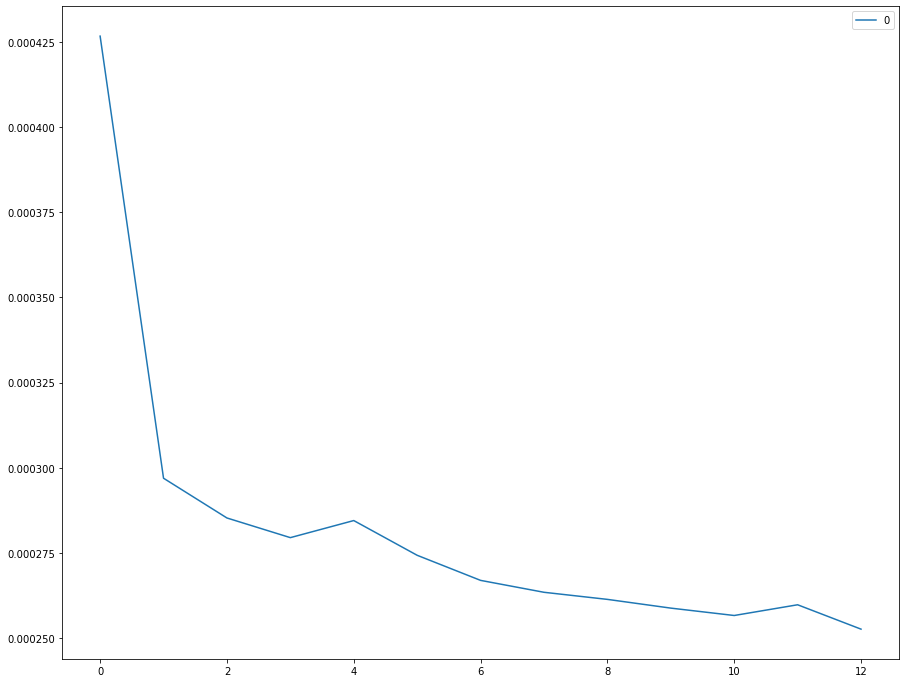

In [161]:
pd.DataFrame(auto_encoder.loss_curve_).plot()

**TODO: Write at which number of iterations the loss reachted its minimum value.**

In [177]:
def key_consine_similarity(tupple):
    return tupple[1]

def get_computed_similarities(vectors, predicted_vectors, reverse=False):
    data_size = len(review_anomalies)
    cosine_similarities = []
    for i in range(data_size):
        cosine_sim_val = (1 - cosine(vectors[i], predicted_vectors[i]))
        cosine_similarities.append((i, cosine_sim_val))
    return sorted(cosine_similarities, key=key_consine_similarity, reverse=reverse)

def display_top_n(sorted_cosine_similarities, n=10):
    for i in range(n):
        index, consine_sim_val = sorted_cosine_similarities[i]
        print('Listing id and review id:', review_anomalies.iloc[index, 0], review_anomalies.iloc[index, 1])  
        print('Cosine Sim Val :', consine_sim_val)
        comment_row = reviews_original[reviews_original['id'] == review_anomalies.iloc[index, 1]]
        print('Comment :', str(comment_row['comments'].iloc[0]))
        print('---------------------------------')

In [179]:
sorted_cosine_similarities = get_computed_similarities(vectors=doc2vec_vectors, predicted_vectors=predicted_vectors)
print('Top 20 anomaly reviews')
display_top_n(sorted_cosine_similarities=sorted_cosine_similarities, n=20)

Top 20 anomaly reviews
Listing id and review id: 21767980 391027947185703227
Cosine Sim Val : -0.21198849380016327
Comment : It's a beautiful apartment.  illuminated, with everything you need, very clean, good location, good communication with the host... simply perfect.
---------------------------------
Listing id and review id: 4975295 64058284
Cosine Sim Val : -0.1972505897283554
Comment : With 7 girls we stayed af Raamhof in Gent. The house is really comfortable and clean and is perfectly located in the city of Gent. Simon is a very good host and we've experienced a really welcome and warm stay.  All basic things needed for our stay were accommodated. Also the practical and nice tips  from Simon of experiencing Gent contributed to a pleasant weekend.This house is the perfect place for big groups or families and I would recommend this place to everyone visiting Gent!
---------------------------------
Listing id and review id: 15266842 139681044
Cosine Sim Val : -0.19157028198242188
